In [20]:
import numpy as np
from tqdm import tqdm
import pymc as pm
import skfem as fem
from skfem.helpers import dot, grad, d, dd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import truncnorm
import scipy.sparse as scsparse
import scipy.optimize as scoptimize
import scipy.linalg as sclinalg

import pytensor.tensor.subtensor as subtensor
import pytensor.tensor as tensor
import arviz as az

# Misspecified Model

In [22]:
number_of_x_axial_cells = 64

x_axis_left_boundary = 0.
x_axis_right_boundary = 1.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

true_coordinates = mesh.p.T
n_x = len(true_coordinates)
boundary_condition = (
    (true_coordinates == x_axis_left_boundary) | (true_coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


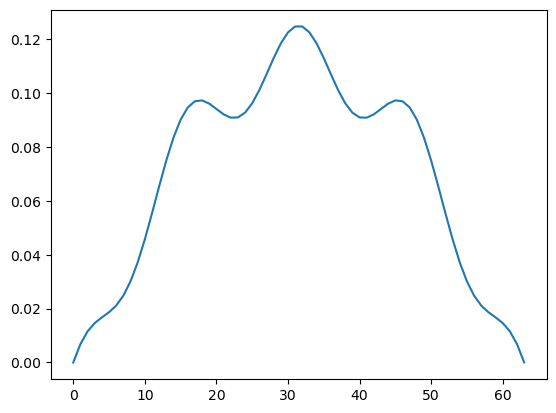

In [23]:
true_alpha = 1.
true_beta = 1.

@fem.LinearForm
def RHS(v,w):
    x = w.x
    f =  8 * np.cos(np.pi*8*x[0]) + true_beta
    return f*v

@fem.BilinearForm
def LHS(u,v,w):
    x = w.x
    return true_alpha*dot(grad(u),grad(v))

A_mat = LHS.assemble(basis)
A_mat[boundary_indices,:] = 0.
A_mat[boundary_indices, boundary_indices] = 1.
L_vec = RHS.assemble(basis)
L_vec[boundary_indices] = 0.

true_u_solution = scsparse.linalg.spsolve(A_mat, L_vec)
plt.plot(true_u_solution)
plt.show()

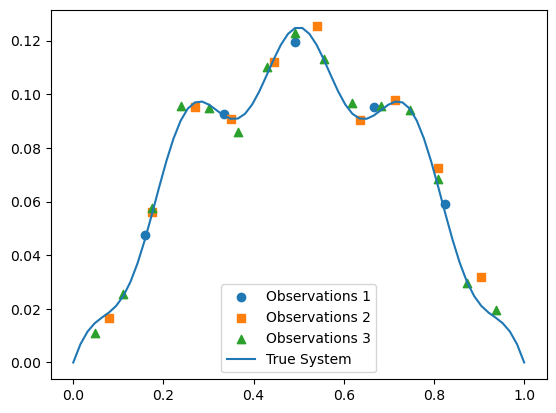

In [24]:
def take_observations(true_solution, true_coordinates, n_obs, noise, boundary = False, equal = False):
    """
    This function takes observations from a vector.

    This function takes in a vector of function values and coordinates, 
    and returns observations, coordinates, and an observation operator.

    Args:
        true_solution (np.array): Vector of true function values.
        true_coordinates (np.array): Vector of function value coordinates.
        n_obs (int): Number of observations to take.
        noise (float): std. of observational noise.
        boundary (np.array): indices of coordinates coinciding with boundary
        equal (bool): If true, will space points out equally in space.

    Returns:
        observation_coordinates (np.array): Subset of true_coordinates representing observed points.
        observation_values (np.array): subset of true_solution with noise added.
        observation_operator (np.array): Observation Operator matrix.
    """
    observation_indices = np.zeros(n_obs, dtype='int64')

    if isinstance(boundary, np.ndarray):
        num_boundary_points = len(boundary)
        if equal == False:
            observation_indices[:num_boundary_points] = boundary
            observation_indices[num_boundary_points:] = np.random.choice(np.arange(num_boundary_points-1, n_x-(num_boundary_points-1)), len(observation_indices[num_boundary_points:]), replace=False)
        else:
            observation_indices = np.linspace(0, len(true_coordinates) - 1, n_obs, dtype=int)
    else:
        if equal == False:
            observation_indices = np.random.choice(np.arange(0, n_x), len(observation_indices), replace=False)
        else:
            overshot = np.linspace(0, len(true_coordinates) - 1, n_obs+2, dtype=int)
            observation_indices = overshot[1:-1]
    
    observation_indices = np.sort(observation_indices)
    observation_coordinates = true_coordinates[observation_indices]
    observation_values = true_solution[observation_indices] + np.random.normal(0, noise, len(observation_indices))

    observation_operator = np.zeros((len(observation_coordinates), len(true_coordinates)))
    for i, y in enumerate(observation_coordinates):
        nearest_index = np.argmin(np.abs(true_coordinates - y))
        observation_operator[i, nearest_index] = 1

    return (observation_coordinates, observation_values, observation_operator)

observation_tools1 = take_observations(true_u_solution, true_coordinates, 5, 0.005, equal=True)
observation_tools2 = take_observations(true_u_solution, true_coordinates, 10, 0.005, equal=True)
observation_tools3 = take_observations(true_u_solution, true_coordinates, 15, 0.005, equal=True)

plt.scatter(observation_tools1[0], observation_tools1[1], label='Observations 1')
plt.scatter(observation_tools2[0], observation_tools2[1], label='Observations 2', marker='s')
plt.scatter(observation_tools3[0], observation_tools3[1], label='Observations 3', marker='^')
plt.plot(true_coordinates, true_u_solution, label='True System')
plt.legend()
plt.show()


# Misspecified Model

In [25]:
number_of_x_axial_cells = 64

x_axis_left_boundary = 0.
x_axis_right_boundary = 1.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

coordinates = mesh.p.T
n_x = len(coordinates)
boundary_condition = (
    (coordinates == x_axis_left_boundary) | (coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

In [26]:
@fem.BilinearForm
def A_form(u,v,w):
    return dot(grad(u), grad(v))

@fem.BilinearForm
def M_form(u,v,w):
    return u*v

@fem.LinearForm
def L_form(v,w):
    return 1.*v

K_theta_1 = np.tile(coordinates, ((n_x, 1)))
K_theta_2 = np.repeat(coordinates, (n_x), axis=0)
K_theta_3 = -tensor.nlinalg.norm(K_theta_1 - K_theta_2,axis=1)
K_theta_3_np = -np.linalg.norm(K_theta_1 - K_theta_2,axis=1)

A_mat = (A_form.assemble(basis)).toarray()
L_vec = L_form.assemble(basis)
M_mat = (M_form.assemble(basis)).toarray()

def A_alpha_mat(alpha):
    A_alpha = alpha*A_mat
    A_alpha = subtensor.set_subtensor(A_alpha[0,:], 0.)
    A_alpha = subtensor.set_subtensor(A_alpha[-1,:], 0.)
    A_alpha = subtensor.set_subtensor(A_alpha[0,0], 1.)
    A_alpha = subtensor.set_subtensor(A_alpha[-1,-1], 1.)
    # A_alpha[0,:] = A_alpha[-1,:] = 0.
    # A_alpha[0,0] = A_alpha[-1,-1] = 1.
    return A_alpha

def L_beta_vec(beta):
    L_beta = beta*L_vec
    L_beta = subtensor.set_subtensor(L_beta[0], 0.)
    L_beta = subtensor.set_subtensor(L_beta[-1], 0.)
    # L_beta[0] = L_beta[-1] = 0.
    return L_beta

def G_theta_mat(rho, ell):
    G_vec = (rho**2)*tensor.math.exp(K_theta_3/(2*(ell**2)))
    return tensor.reshape(G_vec, (n_x, n_x))

def G_theta_mat_np(rho, ell):
    G_vec = (rho**2)*np.exp(K_theta_3_np/(2*(ell**2)))
    return np.reshape(G_vec, (n_x, n_x))

In [32]:
# PRIORS ------------
# alpha
lower = 0.0001
upper = 3.
mu = 1.5
sigma = 0.5
alpha_params = [lower, upper, mu, sigma]

# beta
lower = 0.0001
upper = 3.
mu = 0.5
sigma = 0.5
beta_params = [lower, upper, mu, sigma]

# rho
lower = 0.0001
upper = 1.
mu = 0.1
sigma = 0.01
rho_params = [lower, upper, mu, sigma]

# ell
lower = 0.0001
upper = 3.
mu = 1.
sigma = 0.1
ell_params = [lower, upper, mu, sigma]

# sigma_n
lower = 0.0001
upper = 1.
mu = 0.01
sigma = 0.005
sigma_n_params = [lower, upper, mu, sigma]

# --------------

In [34]:
observation_set = [observation_tools1, observation_tools2, observation_tools3]

traces = []

for current_observation_set in observation_set:

    with pm.Model() as model:
        alpha = pm.TruncatedNormal('alpha', mu=alpha_params[3], sigma=alpha_params[2], lower=alpha_params[0], upper=alpha_params[1])
        beta = pm.TruncatedNormal('beta', mu=beta_params[3], sigma=beta_params[2], lower=beta_params[0], upper=beta_params[1])
        rho = pm.TruncatedNormal('rho', mu=rho_params[3], sigma=rho_params[2], lower=rho_params[0], upper=rho_params[1])
        ell = pm.TruncatedNormal('ell', mu=ell_params[3], sigma=ell_params[2], lower=ell_params[0], upper=ell_params[1])
        sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n_params[3], sigma=sigma_n_params[2], lower=sigma_n_params[0], upper=sigma_n_params[1])
        
        A_alpha = pm.Deterministic('A_alpha', A_alpha_mat(alpha))
        L_beta = pm.Deterministic('L_beta', L_beta_vec(beta))
        G_rho_ell = pm.Deterministic('G_rho_ell', M_mat @ G_theta_mat(rho, ell) @ M_mat.T)

        A_alpha_inv = tensor.nlinalg.matrix_inverse(A_alpha)

        mu_u = pm.Deterministic('mu_u', A_alpha_inv @ L_beta)
        cov_u = pm.Deterministic('cov_u', A_alpha_inv @ G_rho_ell @ A_alpha_inv.T)

        cov_chol = tensor.linalg.cholesky(current_observation_set[2] @ cov_u @ current_observation_set[2].T + sigma_n**2 * np.eye(len(current_observation_set[1])))
        y_obs = pm.MvNormal('y_obs', mu = current_observation_set[2] @ mu_u, chol = cov_chol, observed=current_observation_set[1])
        #trace = pm.sample(draws=300, tune=300)
        #trace = pm.sample(target_accept=0.9)
        #trace = pm.sample(nuts_sampler="numpyro", chains=4, target_accept=0.95)
        trace = pm.sampling.jax.sample_numpyro_nuts(chains=2, chain_method='parallel', target_accept=0.95)

    traces.append(trace)

model0_fpath = 'staticpoisson_traces/trace0.nc'
model1_fpath = 'staticpoisson_traces/trace1.nc'
model2_fpath = 'staticpoisson_traces/trace2.nc'

traces[0].to_netcdf(model0_fpath)
traces[1].to_netcdf(model1_fpath)
traces[2].to_netcdf(model2_fpath)

/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/jax/_src/linear_util.py:192: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/jax/_src/linear_util.py:192: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))
We recommend running at least 4 chains for robust computation of convergence diagnostics
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/jax/_src/linear_util.py:192: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))
There were

'staticpoisson_traces/trace2.nc'

In [35]:
estimated_alpha = np.mean(traces[2].posterior['alpha'].data.flatten())
estimated_beta = np.mean(traces[2].posterior['beta'].data.flatten())
estimated_rho = np.mean(traces[2].posterior['rho'].data.flatten())
estimated_ell = np.mean(traces[2].posterior['ell'].data.flatten())
estimated_sigma_n = np.mean(traces[2].posterior['sigma_n'].data.flatten())

H = observation_set[2][2]
Y = observation_set[2][1]

estimated_A_alpha_mat = estimated_alpha * A_mat
estimated_A_alpha_mat[0,:] = estimated_A_alpha_mat[-1,:] = 0.
estimated_A_alpha_mat[0,0] = estimated_A_alpha_mat[-1,-1] = 1.

inverse_estimated_A_alpha_mat = np.linalg.inv(estimated_A_alpha_mat)

estimated_L_beta_vec = estimated_beta * L_vec
estimated_L_beta_vec[0] = estimated_L_beta_vec[-1] = 0.

estimated_mu_u = np.linalg.solve(estimated_A_alpha_mat, estimated_L_beta_vec)
estimated_cov = inverse_estimated_A_alpha_mat @ M_mat @ G_theta_mat_np(estimated_rho, estimated_ell) @ M_mat.T @ inverse_estimated_A_alpha_mat.T

conditioned_mean = estimated_mu_u + estimated_cov @ H.T @ np.linalg.inv(H @ estimated_cov @ H.T + ((estimated_sigma_n)**2)*np.eye(len(Y))) @ (Y - H @ estimated_mu_u)
conditioned_cov = estimated_cov - estimated_cov @ H.T @ np.linalg.inv(H @ estimated_cov @ H.T + ((estimated_sigma_n)**2)*np.eye(len(Y))) @ H @ estimated_cov

# conditioned_mean = estimated_mu_u + estimated_cov @ H.T @ np.linalg.inv(H @ estimated_cov @ H.T) @ (Y - H @ estimated_mu_u)
# conditioned_cov = estimated_cov - estimated_cov @ H.T @ np.linalg.inv(H @ estimated_cov @ H.T) @ H @ estimated_cov


/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

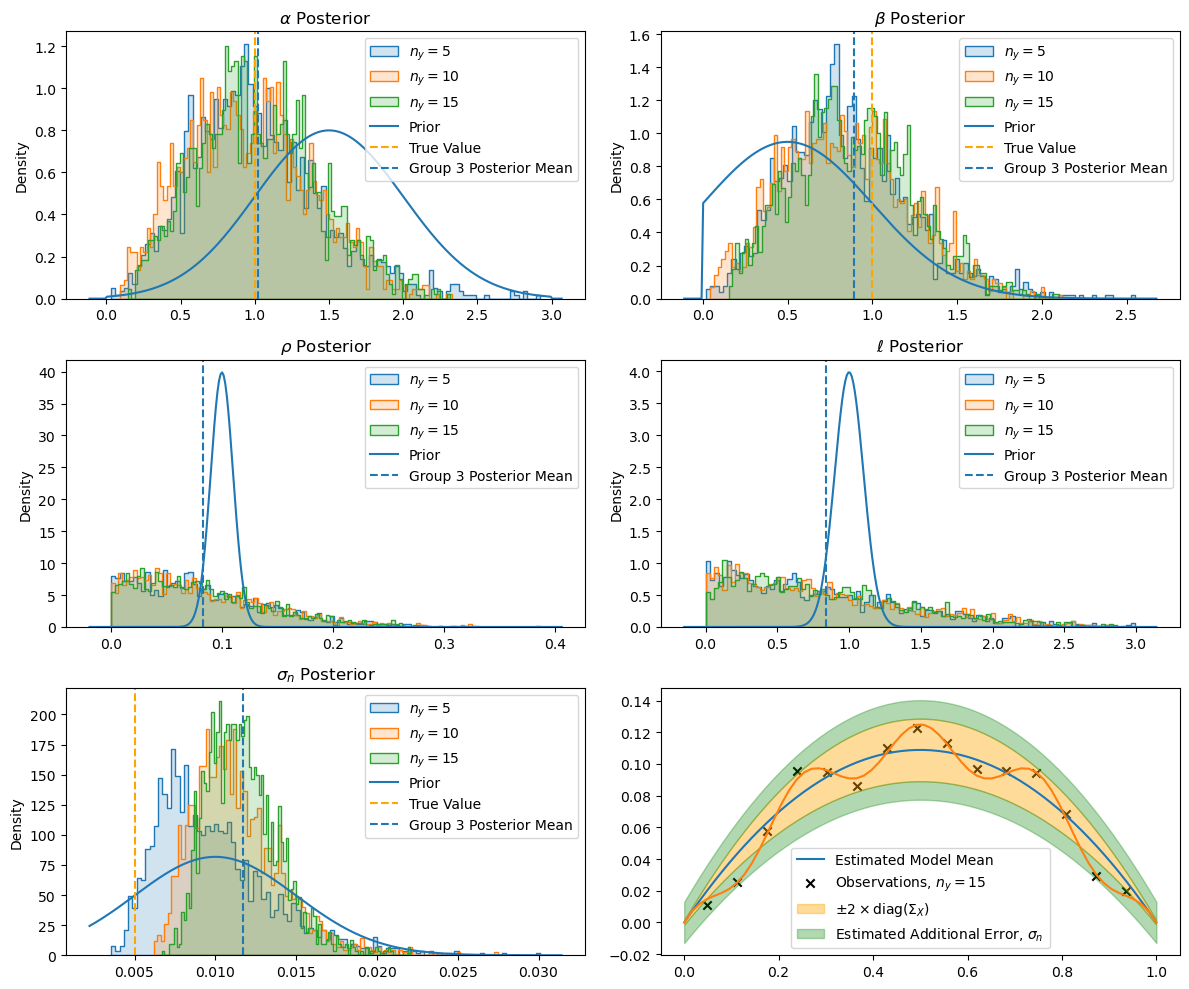

In [36]:
group_labels = [r'$n_y = 5$', r'$n_y = 10$', r'$n_y = 15$']

# Plotting histograms
plt.figure(figsize=(12, 10))

bins_num = 100

plt.subplot(3, 2, 1)
group = 1
for trace in traces:
    if group == 1:
        ax = sns.histplot(trace.posterior['alpha'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=0.2)
    else:
        sns.histplot(trace.posterior['alpha'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=0.2)
    group += 1
x_left, x_right = ax.get_xlim()
bottom_axis = np.linspace(x_left, x_right, 300)
a, b = (alpha_params[0] - alpha_params[2]) / alpha_params[3], (alpha_params[1] - alpha_params[2]) / alpha_params[3]
truncated_normal = truncnorm(a, b, loc=alpha_params[2], scale=alpha_params[3])
plt.plot(bottom_axis, truncated_normal.pdf(bottom_axis), label='Prior')
plt.axvline(true_alpha, color='orange', label='True Value', linestyle='--')
plt.axvline(estimated_alpha, label='Group 3 Posterior Mean', linestyle='--')
plt.legend()
plt.title(r'$\alpha$ Posterior')

plt.subplot(3, 2, 2)
group = 1
for trace in traces:
    if group == 1:
        ax = sns.histplot(trace.posterior['beta'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=0.2)
    else:
        sns.histplot(trace.posterior['beta'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=0.2)
    group += 1
x_left, x_right = ax.get_xlim()
bottom_axis = np.linspace(x_left, x_right, 300)
a, b = (beta_params[0] - beta_params[2]) / beta_params[3], (beta_params[1] - beta_params[2]) / beta_params[3]
truncated_normal = truncnorm(a, b, loc=beta_params[2], scale=beta_params[3])
plt.plot(bottom_axis, truncated_normal.pdf(bottom_axis), label='Prior')
plt.axvline(true_beta, color='orange', label='True Value', linestyle='--')
plt.axvline(estimated_beta, label='Group 3 Posterior Mean', linestyle='--')
plt.legend()
plt.title(r'$\beta$ Posterior')

plt.subplot(3, 2, 3)
group = 1
for trace in traces:
    if group == 1:
        ax = sns.histplot(trace.posterior['rho'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=0.2)
    else:
        sns.histplot(trace.posterior['rho'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=0.2)
    group += 1
x_left, x_right = ax.get_xlim()
bottom_axis = np.linspace(x_left, x_right, 300)
a, b = (rho_params[0] - rho_params[2]) / rho_params[3], (rho_params[1] - rho_params[2]) / rho_params[3]
truncated_normal = truncnorm(a, b, loc=rho_params[2], scale=rho_params[3])
plt.plot(bottom_axis, truncated_normal.pdf(bottom_axis), label='Prior')
plt.axvline(estimated_rho, label='Group 3 Posterior Mean', linestyle='--')
plt.legend()
plt.title(r'$\rho$ Posterior')

plt.subplot(3, 2, 4)
group = 1
for trace in traces:
    if group == 1:
        ax = sns.histplot(trace.posterior['ell'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=0.2)
    else:
        sns.histplot(trace.posterior['ell'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=0.2)
    group += 1
x_left, x_right = ax.get_xlim()
bottom_axis = np.linspace(x_left, x_right, 300)
a, b = (ell_params[0] - ell_params[2]) / ell_params[3], (ell_params[1] - ell_params[2]) / ell_params[3]
truncated_normal = truncnorm(a, b, loc=ell_params[2], scale=ell_params[3])
plt.plot(bottom_axis, truncated_normal.pdf(bottom_axis), label='Prior')
plt.axvline(estimated_ell, label='Group 3 Posterior Mean', linestyle='--')
plt.legend()
plt.title(r'$\ell$ Posterior')

plt.subplot(3, 2, 5)
group = 1
for trace in traces:
    if group == 1:
        ax = sns.histplot(trace.posterior['sigma_n'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=0.2)
    else:
        sns.histplot(trace.posterior['sigma_n'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=0.2)
    group += 1
x_left, x_right = ax.get_xlim()
bottom_axis = np.linspace(x_left, x_right, 300)
a, b = (sigma_n_params[0] - sigma_n_params[2]) / sigma_n_params[3], (sigma_n_params[1] - sigma_n_params[2]) / sigma_n_params[3]
truncated_normal = truncnorm(a, b, loc=sigma_n_params[2], scale=sigma_n_params[3])
plt.plot(bottom_axis, truncated_normal.pdf(bottom_axis), label='Prior')
plt.axvline(0.005, color='orange', label='True Value', linestyle='--')
plt.axvline(estimated_sigma_n, label='Group 3 Posterior Mean', linestyle='--')
plt.legend()
plt.title(r'$\sigma_n$ Posterior')

plt.subplot(3, 2, 6)
plt.plot(coordinates, estimated_mu_u, label='Estimated Model Mean')
plt.scatter(observation_set[2][0], Y, label='Observations, ' + group_labels[2], marker='x', color='black')
plt.fill_between(coordinates.flatten(), estimated_mu_u + 2*np.sqrt(np.diag(estimated_cov)), estimated_mu_u - 2*np.sqrt(np.diag(estimated_cov)), color='orange', alpha=0.4, label=r'$ \pm 2 \times \text{diag}(\Sigma_{X})$')
plt.fill_between(coordinates.flatten(), estimated_mu_u + 2*np.sqrt(np.diag(estimated_cov)), estimated_mu_u + 2*np.sqrt(np.diag(estimated_cov))+ estimated_sigma_n*np.ones(len(coordinates.flatten())), alpha=0.3, color='green', label=r'Estimated Additional Error, $\sigma_n$')
plt.fill_between(coordinates.flatten(), estimated_mu_u - 2*np.sqrt(np.diag(estimated_cov)), estimated_mu_u - 2*np.sqrt(np.diag(estimated_cov))- estimated_sigma_n*np.ones(len(coordinates.flatten())), alpha=0.3, color='green')
plt.plot(true_coordinates, true_u_solution)
plt.legend()

plt.tight_layout()
plt.show()


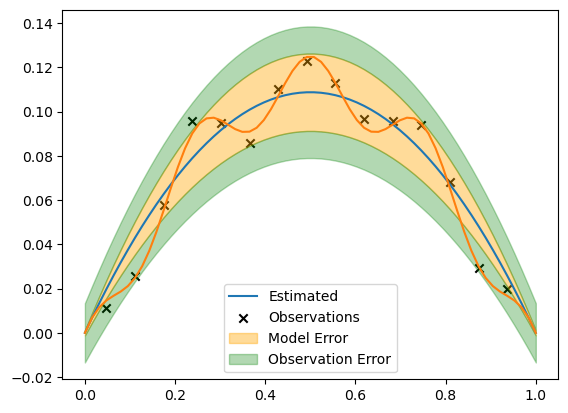

In [31]:
estimated_alpha = np.mean(traces[2].posterior['alpha'].data.flatten())
estimated_beta = np.mean(traces[2].posterior['beta'].data.flatten())
estimated_rho = np.mean(traces[2].posterior['rho'].data.flatten())
estimated_ell = np.mean(traces[2].posterior['ell'].data.flatten())
estimated_sigma_n = np.mean(traces[2].posterior['sigma_n'].data.flatten())

estimated_A_alpha_mat = estimated_alpha * A_mat
estimated_A_alpha_mat[0,:] = estimated_A_alpha_mat[-1,:] = 0.
estimated_A_alpha_mat[0,0] = estimated_A_alpha_mat[-1,-1] = 1.

inverse_estimated_A_alpha_mat = np.linalg.inv(estimated_A_alpha_mat)

estimated_L_beta_vec = estimated_beta * L_vec
estimated_L_beta_vec[0] = estimated_L_beta_vec[-1] = 0.

estimated_mu_u = np.linalg.solve(estimated_A_alpha_mat, estimated_L_beta_vec)
estimated_cov = inverse_estimated_A_alpha_mat @ M_mat @ G_theta_mat_np(estimated_rho, estimated_ell) @ M_mat.T @ inverse_estimated_A_alpha_mat.T

def plot_solution(estimated_mu, estimated_cov, sigma_n):
    plt.plot(coordinates, estimated_mu, label='Estimated')
    plt.scatter(observation_tools3[0], observation_tools3[1], label='Observations', marker='x', color='black')
    plt.fill_between(coordinates.flatten(), estimated_mu + 2*np.sqrt(np.diag(estimated_cov)), estimated_mu - 2*np.sqrt(np.diag(estimated_cov)), color='orange', alpha=0.4, label='Model Error')
    plt.fill_between(coordinates.flatten(), estimated_mu + 2*np.sqrt(np.diag(estimated_cov)), estimated_mu + 2*np.sqrt(np.diag(estimated_cov))+ estimated_sigma_n*np.ones(len(coordinates.flatten())), alpha=0.3, color='green', label='Observation Error')
    plt.fill_between(coordinates.flatten(), estimated_mu - 2*np.sqrt(np.diag(estimated_cov)), estimated_mu - 2*np.sqrt(np.diag(estimated_cov))- estimated_sigma_n*np.ones(len(coordinates.flatten())), alpha=0.3, color='green')
    plt.plot(true_coordinates, true_u_solution)
    plt.legend()
    plt.show()

plot_solution(estimated_mu_u, estimated_cov, estimated_sigma_n)

'staticpoisson_traces/trace2.nc'